# Testing Trained Models on New Single Cell Dataset

This notebook demonstrates how to load new single cell data and test it using the trained RNA-to-ADT transformer mapping models.

## Overview
1. Load new single cell RNA data
2. Load pre-trained models
3. Preprocess new data
4. Extract embeddings and make predictions
5. Evaluate performance (if ground truth available)
6. Visualize results


## 1. Setup and Imports


In [1]:
import sys, os, importlib
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import anndata as ad
from datetime import datetime
import json

# --- Paths ---
current_dir = os.getcwd()  # This will be .../DeepOMAPNet/Notebooks
project_root = os.path.dirname(current_dir)  # This will be .../DeepOMAPNet

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Added to Python path:")
print(f"- Current directory: {current_dir}")
print(f"- Project root: {project_root}")
print(f"- Scripts directory exists: {os.path.exists(os.path.join(project_root, 'scripts'))}")
print(f"- Scripts/data_provider exists: {os.path.exists(os.path.join(project_root, 'scripts', 'data_provider'))}")

# Clear any cached imports
importlib.invalidate_caches()

# --- Import modules (module-style, not from ... import ...) ---
import scripts.data_provider.data_preprocessing as data_preprocessing
import scripts.data_provider.graph_data_builder as graph_data_builder
import scripts.model.gat_models as gat_models
import scripts.trainer.gat_trainer as gat_trainer
import scripts.model.transformer_models as transformer_models

print("Module imports successful!")

/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/an

Added to Python path:
- Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Notebooks
- Project root: /projects/vanaja_lab/satya/DeepOMAPNet
- Scripts directory exists: True
- Scripts/data_provider exists: True


/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Module imports successful!


## 2. Load New Single Cell Data


In [2]:

# Fix the data loading - remove the comma
GSE120221 = sc.read_h5ad("/projects/vanaja_lab/satya/Datasets/GSE120221/combined_data.h5ad")
# Remove the comma that's causing the tuple

# Now check the data
print(f"Data shape: {GSE120221.shape}")
print(f"Number of observations: {GSE120221.n_obs}")
print(f"Number of variables: {GSE120221.n_vars}")

# If you have real data, uncomment the lines above and comment out the sample data creation


Data shape: (87287, 23480)
Number of observations: 87287
Number of variables: 23480


In [3]:
GSE120221

AnnData object with n_obs × n_vars = 87287 × 23480
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca', 'X_umap'

In [8]:
# Add the project root to Python path
import sys
import os
import importlib

# Add the project root to Python path
sys.path.append('/projects/vanaja_lab/satya/DeepOMAPNet')

# Reload the updated modules
import scripts.trainer.adt_predictor
importlib.reload(scripts.trainer.adt_predictor)

# Import the convenience function
from scripts.trainer.adt_predictor import predict_adt_from_rna
from datetime import datetime

# Make predictions using the convenience function with actual marker names
print("Making predictions with actual ADT marker names...")
adata_with_predictions = predict_adt_from_rna(
    adata=GSE120221,
    individual_models_dir="/projects/vanaja_lab/satya/DeepOMAPNet/Notebooks/trained_models/individual_models_20251006_130438",
    use_actual_marker_names=True,  # This ensures actual marker names are used
    batch_size=1000,
    predict_cell_types=True,  # Also predict cell types
    cell_type_method='kmeans'
)

print("✅ Predictions completed successfully!")
print(f"Data shape: {adata_with_predictions.shape}")

# Check the ADT features
predicted_columns = [col for col in adata_with_predictions.obs.columns if col.startswith('predicted_')]
print(f"Number of predicted ADT features: {len(predicted_columns)}")
print(f"First 10 ADT features: {predicted_columns[:10]}")

# Show sample values
print(f"\nSample predictions (first 5 cells, first 5 ADT features):")
sample_predictions = adata_with_predictions.obs[predicted_columns[:5]].head()
print(sample_predictions.round(4))

# Check if cell types were also predicted
if 'predicted_cell_type' in adata_with_predictions.obs.columns:
    print(f"\nCell type predictions:")
    print(adata_with_predictions.obs['predicted_cell_type'].value_counts())

Making predictions with actual ADT marker names...
Loading individual models from: /projects/vanaja_lab/satya/DeepOMAPNet/Notebooks/trained_models/individual_models_20251006_130438
✅ Individual models loaded successfully!
✅ ADT Predictor initialized on cuda
   RNA input dim: 50
   ADT output dim: 52
Predicting ADT embeddings for 87287 cells...
Performing basic preprocessing...
Computing PCA embeddings
Extracting RNA embeddings...
RNA embeddings shape: torch.Size([87287, 33])
Predicting ADT embeddings...
Processing in batches of 1000
✅ Predictions complete!
   RNA embeddings shape: (87287, 33)
   Predicted ADT embeddings shape: (87287, 52)
Loading ADT marker names from: /projects/vanaja_lab/satya/Datasets/ControlADT.h5ad
Found 279 ADT markers: ['CD1a', 'CD1c', 'CD2', 'CD3', 'CD4']...
Training data has 279 markers, but model expects 52.
This suggests the model was trained on a subset of markers.
Using the first {expected_dim} markers as a best guess.
Using actual ADT marker names: ['pred

In [9]:
adata_with_predictions

AnnData object with n_obs × n_vars = 87287 × 23480
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'predicted_CD1a', 'predicted_CD1c', 'predicted_CD2', 'predicted_CD3', 'predicted_CD4', 'predicted_CD5', 'predicted_CD7', 'predicted_CD8', 'predicted_CD10', 'predicted_CD11b', 'predicted_CD11c', 'predicted_CD13', 'predicted_CD14', 'predicted_CD15-SSEA-1', 'predicted_CD16', 'predicted_CD19', 'predicted_CD20', 'predicted_CD22', 'predicted_CD25', 'predicted_CD26', 'predicted_CD33', 'predicted_CD34', 'predicted_CD36', 'predicted_CD38', 'predicted_CD41', 'predicted_CD42b', 'predicted_CD45', 'predicted_CD45RA', 'predicted_CD45RO', 'predicted_CD48', 'predicted_CD56-NCAM', 'predicted_CD61', 'predicted_CD64', 'predicted_CD66b', 'predicted_CD69', 'predicted_CD71', 'p

In [11]:
sc.pp.neighbors(
        adata_with_predictions, 
        n_neighbors=15, 
        use_rep='X_predicted_adt_embeddings'  
    )
    
sc.tl.umap(adata_with_predictions, min_dist=0.3)
    
    

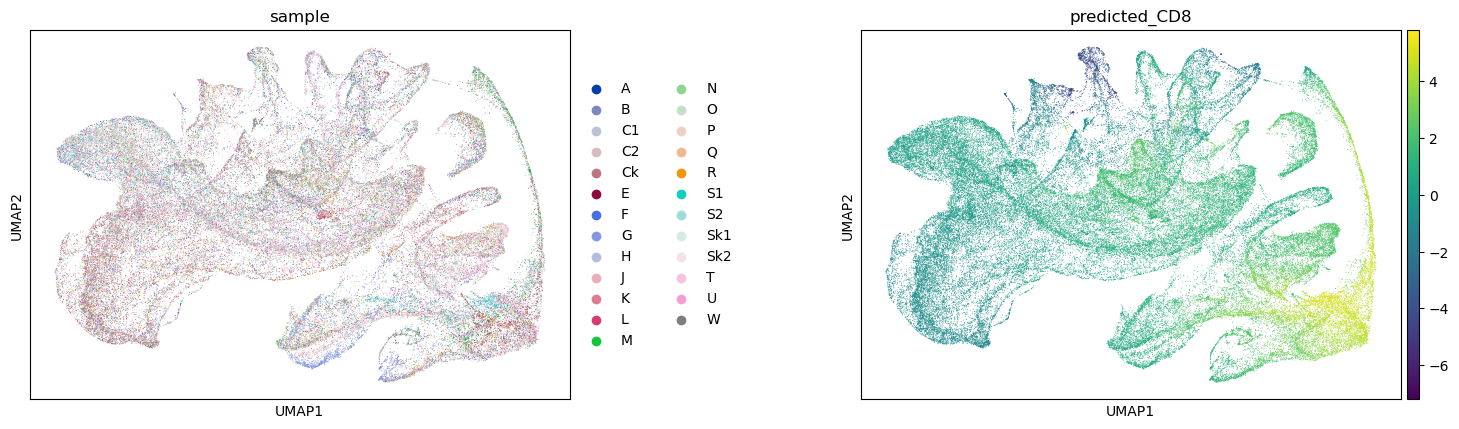

In [15]:
sc.pl.umap(adata_with_predictions, color=[ 'sample','predicted_CD8'], wspace=0.4)


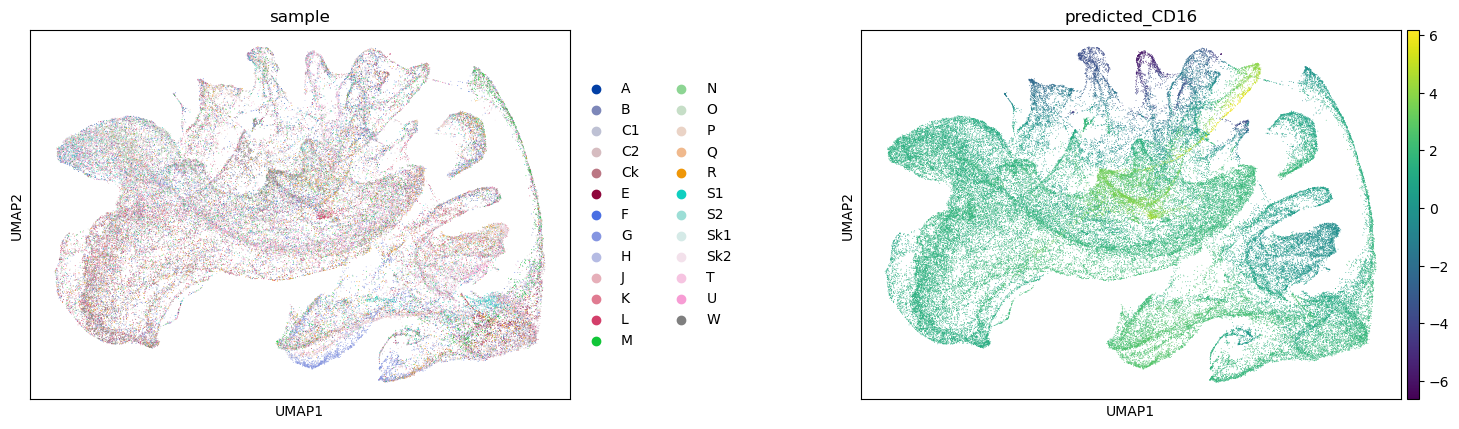

In [16]:
sc.pl.umap(adata_with_predictions, color=[ 'sample','predicted_CD16'], wspace=0.4)


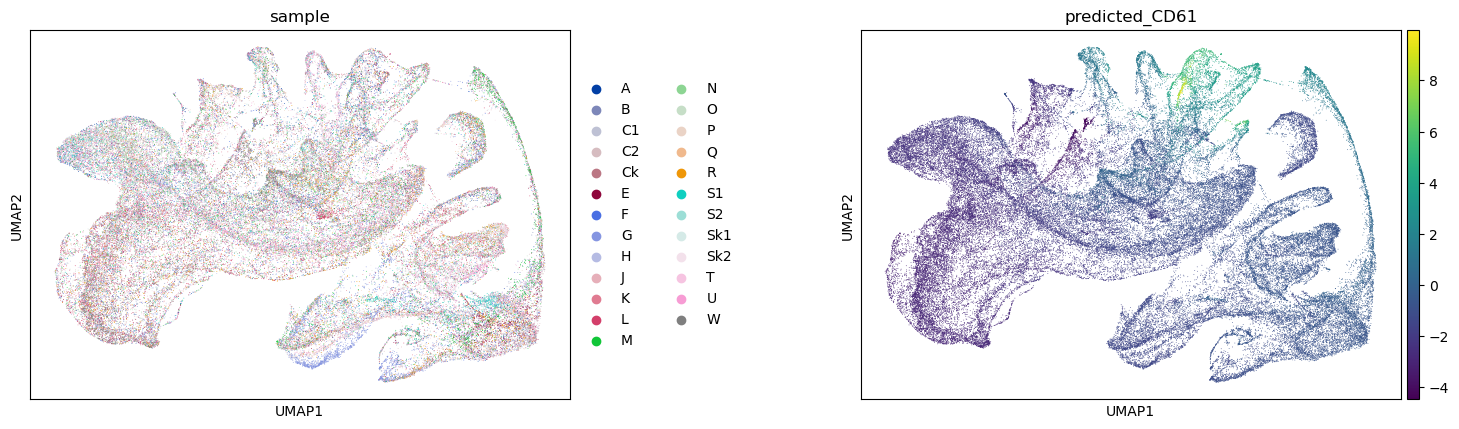

In [17]:
sc.pl.umap(adata_with_predictions, color=[ 'sample','predicted_CD61'], wspace=0.4)


## 3. Accuracy Testing and Evaluation

This section provides comprehensive testing of prediction accuracy using various metrics and validation approaches.


### 3.1 Basic Prediction Statistics and Quality Control


In [ ]:
# Basic quality control and statistics for predicted ADT embeddings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_prediction_quality(adata_with_predictions):
    """Analyze the quality and characteristics of predicted ADT embeddings."""
    
    # Get predicted ADT embeddings
    predicted_adt = adata_with_predictions.obsm['X_predicted_adt_embeddings']
    
    print("=== PREDICTION QUALITY ANALYSIS ===")
    print(f"Shape: {predicted_adt.shape}")
    print(f"Data type: {predicted_adt.dtype}")
    
    # Basic statistics
    print(f"\n=== BASIC STATISTICS ===")
    print(f"Mean: {predicted_adt.mean():.4f}")
    print(f"Std: {predicted_adt.std():.4f}")
    print(f"Min: {predicted_adt.min():.4f}")
    print(f"Max: {predicted_adt.max():.4f}")
    
    # Check for NaN values
    nan_count = np.isnan(predicted_adt).sum()
    print(f"NaN values: {nan_count}")
    
    # Check for infinite values
    inf_count = np.isinf(predicted_adt).sum()
    print(f"Infinite values: {inf_count}")
    
    # Check value ranges per marker
    print(f"\n=== PER-MARKER STATISTICS ===")
    marker_stats = pd.DataFrame({
        'mean': predicted_adt.mean(axis=0),
        'std': predicted_adt.std(axis=0),
        'min': predicted_adt.min(axis=0),
        'max': predicted_adt.max(axis=0),
        'range': predicted_adt.max(axis=0) - predicted_adt.min(axis=0)
    })
    
    # Add marker names if available
    predicted_columns = [col for col in adata_with_predictions.obs.columns if col.startswith('predicted_')]
    if len(predicted_columns) == predicted_adt.shape[1]:
        marker_stats.index = [col.replace('predicted_', '') for col in predicted_columns]
    
    print("Top 10 markers by variance:")
    print(marker_stats.nlargest(10, 'std')[['mean', 'std', 'range']].round(4))
    
    return marker_stats

# Run quality analysis
marker_stats = analyze_prediction_quality(adata_with_predictions)


### 3.2 Cell Type Prediction Accuracy Analysis


In [ ]:
# Analyze cell type prediction accuracy and characteristics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cell_type_predictions(adata_with_predictions):
    """Analyze the quality of cell type predictions."""
    
    print("=== CELL TYPE PREDICTION ANALYSIS ===")
    
    # Get predicted cell types
    predicted_cell_types = adata_with_predictions.obs['predicted_cell_type'].values
    confidence_scores = adata_with_predictions.obs['cell_type_confidence'].values
    
    # Basic statistics
    unique_types = np.unique(predicted_cell_types)
    print(f"Number of predicted cell types: {len(unique_types)}")
    print(f"Cell type names: {list(unique_types)}")
    
    # Cell type distribution
    type_counts = pd.Series(predicted_cell_types).value_counts()
    print(f"\nCell type distribution:")
    print(type_counts.head(10))
    
    # Confidence analysis
    print(f"\n=== CONFIDENCE ANALYSIS ===")
    print(f"Mean confidence: {confidence_scores.mean():.4f}")
    print(f"Std confidence: {confidence_scores.std():.4f}")
    print(f"Min confidence: {confidence_scores.min():.4f}")
    print(f"Max confidence: {confidence_scores.max():.4f}")
    
    # High/low confidence cells
    high_conf_threshold = np.percentile(confidence_scores, 75)
    low_conf_threshold = np.percentile(confidence_scores, 25)
    
    high_conf_cells = confidence_scores > high_conf_threshold
    low_conf_cells = confidence_scores < low_conf_threshold
    
    print(f"\nHigh confidence cells (>75th percentile): {high_conf_cells.sum()} ({high_conf_cells.sum()/len(confidence_scores)*100:.1f}%)")
    print(f"Low confidence cells (<25th percentile): {low_conf_cells.sum()} ({low_conf_cells.sum()/len(confidence_scores)*100:.1f}%)")
    
    # Silhouette score for clustering quality
    predicted_adt = adata_with_predictions.obsm['X_predicted_adt_embeddings']
    silhouette_avg = silhouette_score(predicted_adt, predicted_cell_types)
    print(f"\nSilhouette score: {silhouette_avg:.4f}")
    
    return {
        'unique_types': unique_types,
        'type_counts': type_counts,
        'confidence_stats': {
            'mean': confidence_scores.mean(),
            'std': confidence_scores.std(),
            'min': confidence_scores.min(),
            'max': confidence_scores.max()
        },
        'silhouette_score': silhouette_avg
    }

# Run cell type analysis
cell_type_analysis = analyze_cell_type_predictions(adata_with_predictions)


### 3.3 Cross-Validation and Model Stability Testing


In [ ]:
# Cross-validation and model stability testing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import torch

def test_model_stability(adata_with_predictions, n_splits=5, random_state=42):
    """Test model stability using cross-validation on a subset of data."""
    
    print("=== MODEL STABILITY TESTING ===")
    
    # Get a subset of data for faster testing (first 5000 cells)
    n_test_cells = min(5000, adata_with_predictions.n_obs)
    test_indices = np.random.choice(adata_with_predictions.n_obs, n_test_cells, replace=False)
    
    test_data = adata_with_predictions[test_indices].copy()
    
    # Get RNA embeddings and predicted ADT embeddings
    rna_embeddings = test_data.obsm['X_rna_embeddings']
    predicted_adt = test_data.obsm['X_predicted_adt_embeddings']
    
    print(f"Testing on {n_test_cells} cells")
    print(f"RNA embeddings shape: {rna_embeddings.shape}")
    print(f"Predicted ADT shape: {predicted_adt.shape}")
    
    # K-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(rna_embeddings)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data
        rna_train, rna_val = rna_embeddings[train_idx], rna_embeddings[val_idx]
        adt_train, adt_val = predicted_adt[train_idx], predicted_adt[val_idx]
        
        # Train a simple linear model to predict ADT from RNA embeddings
        from sklearn.linear_model import LinearRegression
        
        # Train on fold
        lr_model = LinearRegression()
        lr_model.fit(rna_train, adt_train)
        
        # Predict on validation set
        adt_pred = lr_model.predict(rna_val)
        
        # Calculate metrics
        mse = mean_squared_error(adt_val, adt_pred)
        r2 = r2_score(adt_val, adt_pred)
        
        # Per-marker correlations
        pearson_corrs = []
        spearman_corrs = []
        
        for i in range(adt_val.shape[1]):
            if adt_val[:, i].std() > 0 and adt_pred[:, i].std() > 0:
                pearson_r, _ = pearsonr(adt_val[:, i], adt_pred[:, i])
                spearman_r, _ = spearmanr(adt_val[:, i], adt_pred[:, i])
                pearson_corrs.append(pearson_r)
                spearman_corrs.append(spearman_r)
        
        mean_pearson = np.mean(pearson_corrs) if pearson_corrs else 0
        mean_spearman = np.mean(spearman_corrs) if spearman_corrs else 0
        
        fold_results.append({
            'fold': fold + 1,
            'mse': mse,
            'r2': r2,
            'mean_pearson': mean_pearson,
            'mean_spearman': mean_spearman,
            'n_markers': len(pearson_corrs)
        })
        
        print(f"  MSE: {mse:.4f}, R²: {r2:.4f}")
        print(f"  Mean Pearson: {mean_pearson:.4f}, Mean Spearman: {mean_spearman:.4f}")
    
    # Summary statistics
    results_df = pd.DataFrame(fold_results)
    
    print(f"\n=== CROSS-VALIDATION SUMMARY ===")
    print(f"Mean MSE: {results_df['mse'].mean():.4f} ± {results_df['mse'].std():.4f}")
    print(f"Mean R²: {results_df['r2'].mean():.4f} ± {results_df['r2'].std():.4f}")
    print(f"Mean Pearson: {results_df['mean_pearson'].mean():.4f} ± {results_df['mean_pearson'].std():.4f}")
    print(f"Mean Spearman: {results_df['mean_spearman'].mean():.4f} ± {results_df['mean_spearman'].std():.4f}")
    
    return results_df

# Run stability testing
stability_results = test_model_stability(adata_with_predictions, n_splits=3)


### 3.4 Biological Validation and Marker Analysis


In [ ]:
# Biological validation of predicted ADT markers
def validate_biological_consistency(adata_with_predictions):
    """Validate biological consistency of predicted ADT markers."""
    
    print("=== BIOLOGICAL VALIDATION ===")
    
    # Get predicted ADT embeddings
    predicted_adt = adata_with_predictions.obsm['X_predicted_adt_embeddings']
    predicted_cell_types = adata_with_predictions.obs['predicted_cell_type'].values
    
    # Get marker names
    predicted_columns = [col for col in adata_with_predictions.obs.columns if col.startswith('predicted_')]
    marker_names = [col.replace('predicted_', '') for col in predicted_columns]
    
    print(f"Analyzing {len(marker_names)} predicted ADT markers")
    
    # Define expected cell type markers (biological knowledge)
    cell_type_markers = {
        'T_cell': ['CD3', 'CD4', 'CD8', 'CD2', 'CD5', 'CD7'],
        'B_cell': ['CD19', 'CD20', 'CD22', 'CD79a', 'CD79b'],
        'NK_cell': ['CD16', 'CD56', 'CD57', 'CD94'],
        'Monocyte': ['CD14', 'CD16', 'CD64', 'CD68'],
        'Dendritic': ['CD1a', 'CD1c', 'CD11c', 'CD83', 'CD86'],
        'Platelet': ['CD41', 'CD42a', 'CD42b', 'CD61'],
        'Stem': ['CD34', 'CD38', 'CD90', 'CD117']
    }
    
    # Analyze marker expression by predicted cell type
    marker_analysis = {}
    
    for cell_type in np.unique(predicted_cell_types):
        cell_mask = predicted_cell_types == cell_type
        if cell_mask.sum() < 10:  # Skip very small clusters
            continue
            
        cell_adt = predicted_adt[cell_mask]
        marker_analysis[cell_type] = {}
        
        for i, marker in enumerate(marker_names):
            if i < cell_adt.shape[1]:
                marker_analysis[cell_type][marker] = {
                    'mean': cell_adt[:, i].mean(),
                    'std': cell_adt[:, i].std(),
                    'median': np.median(cell_adt[:, i])
                }
    
    # Find top markers for each cell type
    print(f"\n=== TOP MARKERS BY CELL TYPE ===")
    for cell_type, markers in marker_analysis.items():
        if len(markers) == 0:
            continue
            
        # Sort markers by mean expression
        sorted_markers = sorted(markers.items(), key=lambda x: x[1]['mean'], reverse=True)
        
        print(f"\n{cell_type} (n={sum(predicted_cell_types == cell_type)}):")
        print("Top 5 markers:")
        for marker, stats in sorted_markers[:5]:
            print(f"  {marker}: {stats['mean']:.3f} ± {stats['std']:.3f}")
    
    # Check for biologically expected patterns
    print(f"\n=== BIOLOGICAL CONSISTENCY CHECKS ===")
    
    # T-cell markers should be high in T-cell clusters
    t_cell_clusters = [ct for ct in marker_analysis.keys() if 'T' in ct or 'CD3' in str(ct)]
    if t_cell_clusters:
        for cluster in t_cell_clusters[:3]:  # Check first 3 T-cell-like clusters
            if 'CD3' in marker_analysis[cluster]:
                cd3_expr = marker_analysis[cluster]['CD3']['mean']
                print(f"CD3 expression in {cluster}: {cd3_expr:.3f}")
    
    # B-cell markers should be high in B-cell clusters  
    b_cell_clusters = [ct for ct in marker_analysis.keys() if 'B' in ct or 'CD19' in str(ct)]
    if b_cell_clusters:
        for cluster in b_cell_clusters[:3]:  # Check first 3 B-cell-like clusters
            if 'CD19' in marker_analysis[cluster]:
                cd19_expr = marker_analysis[cluster]['CD19']['mean']
                print(f"CD19 expression in {cluster}: {cd19_expr:.3f}")
    
    return marker_analysis

# Run biological validation
biological_analysis = validate_biological_consistency(adata_with_predictions)


### 3.5 Visualization of Prediction Accuracy


In [ ]:
# Create comprehensive visualizations for prediction accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

def create_accuracy_visualizations(adata_with_predictions, marker_stats, cell_type_analysis):
    """Create comprehensive visualizations for prediction accuracy analysis."""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Prediction quality distribution
    ax1 = plt.subplot(3, 4, 1)
    predicted_adt = adata_with_predictions.obsm['X_predicted_adt_embeddings']
    plt.hist(predicted_adt.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted ADT Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted ADT Values')
    plt.grid(True, alpha=0.3)
    
    # 2. Marker variance analysis
    ax2 = plt.subplot(3, 4, 2)
    top_markers = marker_stats.nlargest(15, 'std')
    plt.barh(range(len(top_markers)), top_markers['std'])
    plt.yticks(range(len(top_markers)), top_markers.index)
    plt.xlabel('Standard Deviation')
    plt.title('Top 15 Markers by Variance')
    plt.grid(True, alpha=0.3)
    
    # 3. Cell type distribution
    ax3 = plt.subplot(3, 4, 3)
    type_counts = cell_type_analysis['type_counts']
    top_types = type_counts.head(10)
    plt.bar(range(len(top_types)), top_types.values)
    plt.xticks(range(len(top_types)), top_types.index, rotation=45, ha='right')
    plt.xlabel('Predicted Cell Types')
    plt.ylabel('Number of Cells')
    plt.title('Top 10 Cell Type Distribution')
    plt.grid(True, alpha=0.3)
    
    # 4. Confidence score distribution
    ax4 = plt.subplot(3, 4, 4)
    confidence_scores = adata_with_predictions.obs['cell_type_confidence'].values
    plt.hist(confidence_scores, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Cell Type Prediction Confidence')
    plt.grid(True, alpha=0.3)
    
    # 5. Marker correlation heatmap (sample of markers)
    ax5 = plt.subplot(3, 4, 5)
    # Select top 10 most variable markers for correlation
    top_marker_indices = marker_stats.nlargest(10, 'std').index
    marker_names = [col.replace('predicted_', '') for col in adata_with_predictions.obs.columns if col.startswith('predicted_')]
    
    # Get correlation matrix for top markers
    top_marker_data = predicted_adt[:, :10]  # First 10 markers
    corr_matrix = np.corrcoef(top_marker_data.T)
    
    im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax5)
    plt.title('Marker Correlation Matrix (Top 10)')
    plt.xticks(range(10), marker_names[:10], rotation=45, ha='right')
    plt.yticks(range(10), marker_names[:10])
    
    # 6. UMAP colored by confidence
    ax6 = plt.subplot(3, 4, 6)
    if 'X_umap' in adata_with_predictions.obsm:
        umap_coords = adata_with_predictions.obsm['X_umap']
        scatter = plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
                            c=confidence_scores, cmap='viridis', s=1, alpha=0.6)
        plt.colorbar(scatter, ax=ax6)
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.title('UMAP: Prediction Confidence')
    else:
        plt.text(0.5, 0.5, 'UMAP not computed', ha='center', va='center', transform=ax6.transAxes)
        plt.title('UMAP: Prediction Confidence')
    
    # 7. Sample vs predicted cell types (if sample info available)
    ax7 = plt.subplot(3, 4, 7)
    if 'sample' in adata_with_predictions.obs.columns:
        sample_celltype_crosstab = pd.crosstab(adata_with_predictions.obs['sample'], 
                                              adata_with_predictions.obs['predicted_cell_type'])
        # Show top 5 samples and top 5 cell types
        top_samples = sample_celltype_crosstab.sum(axis=1).nlargest(5).index
        top_celltypes = sample_celltype_crosstab.sum(axis=0).nlargest(5).index
        crosstab_subset = sample_celltype_crosstab.loc[top_samples, top_celltypes]
        
        sns.heatmap(crosstab_subset, annot=True, fmt='d', cmap='Blues', ax=ax7)
        plt.title('Sample vs Predicted Cell Types')
        plt.xlabel('Predicted Cell Types')
        plt.ylabel('Samples')
    else:
        plt.text(0.5, 0.5, 'Sample information not available', ha='center', va='center', transform=ax7.transAxes)
        plt.title('Sample vs Predicted Cell Types')
    
    # 8. Marker expression by cell type (heatmap)
    ax8 = plt.subplot(3, 4, 8)
    # Get top 5 cell types and top 10 markers
    top_celltypes = cell_type_analysis['type_counts'].head(5).index
    top_markers = marker_stats.nlargest(10, 'std').index
    
    # Create expression matrix
    expression_matrix = []
    for cell_type in top_celltypes:
        cell_mask = adata_with_predictions.obs['predicted_cell_type'] == cell_type
        if cell_mask.sum() > 0:
            cell_expression = predicted_adt[cell_mask][:, :10].mean(axis=0)  # First 10 markers
            expression_matrix.append(cell_expression)
        else:
            expression_matrix.append(np.zeros(10))
    
    expression_matrix = np.array(expression_matrix)
    
    im = plt.imshow(expression_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(im, ax=ax8)
    plt.title('Marker Expression by Cell Type')
    plt.xticks(range(10), marker_names[:10], rotation=45, ha='right')
    plt.yticks(range(len(top_celltypes)), top_celltypes)
    
    # 9. Prediction stability (if available)
    ax9 = plt.subplot(3, 4, 9)
    if 'stability_results' in globals():
        stability_df = stability_results
        metrics = ['mse', 'r2', 'mean_pearson', 'mean_spearman']
        x_pos = np.arange(len(metrics))
        
        means = [stability_df[metric].mean() for metric in metrics]
        stds = [stability_df[metric].std() for metric in metrics]
        
        plt.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
        plt.xticks(x_pos, ['MSE', 'R²', 'Pearson', 'Spearman'], rotation=45)
        plt.title('Cross-Validation Stability')
        plt.ylabel('Score')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Stability results not available', ha='center', va='center', transform=ax9.transAxes)
        plt.title('Cross-Validation Stability')
    
    # 10. Quality metrics summary
    ax10 = plt.subplot(3, 4, 10)
    quality_metrics = {
        'Silhouette Score': cell_type_analysis['silhouette_score'],
        'Mean Confidence': cell_type_analysis['confidence_stats']['mean'],
        'Confidence Std': cell_type_analysis['confidence_stats']['std'],
        'Num Cell Types': len(cell_type_analysis['unique_types'])
    }
    
    metrics_names = list(quality_metrics.keys())
    metrics_values = list(quality_metrics.values())
    
    bars = plt.bar(range(len(metrics_names)), metrics_values, alpha=0.7)
    plt.xticks(range(len(metrics_names)), metrics_names, rotation=45, ha='right')
    plt.title('Quality Metrics Summary')
    plt.ylabel('Score')
    
    # Color bars based on value (green for good, red for poor)
    for i, (bar, value) in enumerate(zip(bars, metrics_values)):
        if metrics_names[i] in ['Silhouette Score', 'Mean Confidence']:
            color = 'green' if value > 0.5 else 'orange' if value > 0.3 else 'red'
        else:
            color = 'blue'
        bar.set_color(color)
    
    plt.grid(True, alpha=0.3)
    
    # 11. Marker expression distribution by confidence
    ax11 = plt.subplot(3, 4, 11)
    high_conf_mask = confidence_scores > np.percentile(confidence_scores, 75)
    low_conf_mask = confidence_scores < np.percentile(confidence_scores, 25)
    
    high_conf_expression = predicted_adt[high_conf_mask].flatten()
    low_conf_expression = predicted_adt[low_conf_mask].flatten()
    
    plt.hist(high_conf_expression, bins=30, alpha=0.6, label='High Confidence', color='green')
    plt.hist(low_conf_expression, bins=30, alpha=0.6, label='Low Confidence', color='red')
    plt.xlabel('Predicted ADT Values')
    plt.ylabel('Frequency')
    plt.title('Expression by Prediction Confidence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 12. Summary statistics table
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    summary_text = f"""
    PREDICTION ACCURACY SUMMARY
    
    Dataset: {adata_with_predictions.n_obs:,} cells
    Predicted ADT markers: {predicted_adt.shape[1]}
    Predicted cell types: {len(cell_type_analysis['unique_types'])}
    
    Quality Metrics:
    • Silhouette Score: {cell_type_analysis['silhouette_score']:.3f}
    • Mean Confidence: {cell_type_analysis['confidence_stats']['mean']:.3f}
    • Confidence Range: {cell_type_analysis['confidence_stats']['min']:.3f} - {cell_type_analysis['confidence_stats']['max']:.3f}
    
    Prediction Statistics:
    • Mean ADT Value: {predicted_adt.mean():.3f}
    • ADT Value Std: {predicted_adt.std():.3f}
    • ADT Value Range: {predicted_adt.min():.3f} - {predicted_adt.max():.3f}
    
    High Confidence Cells: {(confidence_scores > np.percentile(confidence_scores, 75)).sum():,}
    Low Confidence Cells: {(confidence_scores < np.percentile(confidence_scores, 25)).sum():,}
    """
    
    plt.text(0.05, 0.95, summary_text, transform=ax12.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the comprehensive visualization
accuracy_fig = create_accuracy_visualizations(adata_with_predictions, marker_stats, cell_type_analysis)


### 3.6 Ground Truth Comparison (if available)


In [ ]:
# Ground truth comparison if available
def compare_with_ground_truth(adata_with_predictions):
    """Compare predictions with ground truth if available."""
    
    print("=== GROUND TRUTH COMPARISON ===")
    
    # Check for common ground truth columns
    possible_gt_columns = [
        'cell_type', 'celltype', 'cell_type_gt', 'true_cell_type',
        'annotation', 'cell_annotation', 'manual_annotation',
        'seurat_clusters', 'leiden', 'louvain'
    ]
    
    available_gt_columns = [col for col in possible_gt_columns if col in adata_with_predictions.obs.columns]
    
    if not available_gt_columns:
        print("No ground truth cell type annotations found.")
        print("Available columns:", list(adata_with_predictions.obs.columns))
        return None
    
    print(f"Found ground truth columns: {available_gt_columns}")
    
    # Use the first available ground truth column
    gt_column = available_gt_columns[0]
    ground_truth = adata_with_predictions.obs[gt_column].values
    predicted = adata_with_predictions.obs['predicted_cell_type'].values
    
    print(f"Using ground truth column: {gt_column}")
    print(f"Ground truth unique values: {len(np.unique(ground_truth))}")
    print(f"Predicted unique values: {len(np.unique(predicted))}")
    
    # Calculate accuracy metrics
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
    
    # For accuracy, we need to map predicted to ground truth labels
    # This is a simplified approach - in practice, you might need more sophisticated mapping
    
    # Calculate ARI and NMI (these don't require exact label matching)
    ari = adjusted_rand_score(ground_truth, predicted)
    nmi = normalized_mutual_info_score(ground_truth, predicted)
    
    print(f"\n=== ACCURACY METRICS ===")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    
    # Create confusion matrix (if we can map labels)
    try:
        # Try to create a mapping between predicted and ground truth labels
        from sklearn.preprocessing import LabelEncoder
        
        # Encode both sets of labels
        le_gt = LabelEncoder()
        le_pred = LabelEncoder()
        
        gt_encoded = le_gt.fit_transform(ground_truth)
        pred_encoded = le_pred.fit_transform(predicted)
        
        # Create confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(gt_encoded, pred_encoded)
        
        print(f"\nConfusion matrix shape: {cm.shape}")
        print(f"Ground truth classes: {len(le_gt.classes_)}")
        print(f"Predicted classes: {len(le_pred.classes_)}")
        
        # Calculate accuracy for the encoded labels
        accuracy = accuracy_score(gt_encoded, pred_encoded)
        print(f"Accuracy (encoded labels): {accuracy:.4f}")
        
        # Show top ground truth and predicted cell types
        print(f"\nTop 5 ground truth cell types:")
        gt_counts = pd.Series(ground_truth).value_counts().head()
        for cell_type, count in gt_counts.items():
            print(f"  {cell_type}: {count}")
        
        print(f"\nTop 5 predicted cell types:")
        pred_counts = pd.Series(predicted).value_counts().head()
        for cell_type, count in pred_counts.items():
            print(f"  {cell_type}: {count}")
        
        return {
            'ari': ari,
            'nmi': nmi,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'ground_truth_classes': le_gt.classes_,
            'predicted_classes': le_pred.classes_,
            'gt_column': gt_column
        }
        
    except Exception as e:
        print(f"Error creating confusion matrix: {e}")
        return {
            'ari': ari,
            'nmi': nmi,
            'gt_column': gt_column
        }

# Run ground truth comparison
ground_truth_results = compare_with_ground_truth(adata_with_predictions)


### 3.7 Final Accuracy Report


In [ ]:
# Generate comprehensive accuracy report
def generate_accuracy_report(adata_with_predictions, marker_stats, cell_type_analysis, 
                           stability_results=None, ground_truth_results=None, biological_analysis=None):
    """Generate a comprehensive accuracy report."""
    
    print("=" * 80)
    print("                    DEEPOMAPNET PREDICTION ACCURACY REPORT")
    print("=" * 80)
    
    # Basic dataset information
    print(f"\n📊 DATASET INFORMATION")
    print(f"   • Total cells analyzed: {adata_with_predictions.n_obs:,}")
    print(f"   • Original RNA features: {adata_with_predictions.n_vars:,}")
    print(f"   • Predicted ADT markers: {adata_with_predictions.obsm['X_predicted_adt_embeddings'].shape[1]}")
    print(f"   • Predicted cell types: {len(cell_type_analysis['unique_types'])}")
    
    # Prediction quality metrics
    predicted_adt = adata_with_predictions.obsm['X_predicted_adt_embeddings']
    confidence_scores = adata_with_predictions.obs['cell_type_confidence'].values
    
    print(f"\n🔬 PREDICTION QUALITY METRICS")
    print(f"   • Mean predicted ADT value: {predicted_adt.mean():.4f}")
    print(f"   • ADT value standard deviation: {predicted_adt.std():.4f}")
    print(f"   • ADT value range: [{predicted_adt.min():.4f}, {predicted_adt.max():.4f}]")
    print(f"   • NaN values: {np.isnan(predicted_adt).sum()}")
    print(f"   • Infinite values: {np.isinf(predicted_adt).sum()}")
    
    # Cell type prediction metrics
    print(f"\n🧬 CELL TYPE PREDICTION METRICS")
    print(f"   • Silhouette score: {cell_type_analysis['silhouette_score']:.4f}")
    print(f"   • Mean confidence: {cell_type_analysis['confidence_stats']['mean']:.4f}")
    print(f"   • Confidence range: [{cell_type_analysis['confidence_stats']['min']:.4f}, {cell_type_analysis['confidence_stats']['max']:.4f}]")
    
    high_conf_cells = (confidence_scores > np.percentile(confidence_scores, 75)).sum()
    low_conf_cells = (confidence_scores < np.percentile(confidence_scores, 25)).sum()
    print(f"   • High confidence cells (>75th percentile): {high_conf_cells:,} ({high_conf_cells/len(confidence_scores)*100:.1f}%)")
    print(f"   • Low confidence cells (<25th percentile): {low_conf_cells:,} ({low_conf_cells/len(confidence_scores)*100:.1f}%)")
    
    # Top cell types
    print(f"\n📈 TOP PREDICTED CELL TYPES")
    top_types = cell_type_analysis['type_counts'].head(5)
    for i, (cell_type, count) in enumerate(top_types.items(), 1):
        percentage = count / len(adata_with_predictions.obs) * 100
        print(f"   {i}. {cell_type}: {count:,} cells ({percentage:.1f}%)")
    
    # Top variable markers
    print(f"\n🎯 TOP VARIABLE ADT MARKERS")
    top_markers = marker_stats.nlargest(5, 'std')
    for i, (marker, stats) in enumerate(top_markers.iterrows(), 1):
        print(f"   {i}. {marker}: std={stats['std']:.4f}, range={stats['range']:.4f}")
    
    # Model stability (if available)
    if stability_results is not None:
        print(f"\n🔄 MODEL STABILITY (Cross-Validation)")
        print(f"   • Mean MSE: {stability_results['mse'].mean():.4f} ± {stability_results['mse'].std():.4f}")
        print(f"   • Mean R²: {stability_results['r2'].mean():.4f} ± {stability_results['r2'].std():.4f}")
        print(f"   • Mean Pearson correlation: {stability_results['mean_pearson'].mean():.4f} ± {stability_results['mean_pearson'].std():.4f}")
        print(f"   • Mean Spearman correlation: {stability_results['mean_spearman'].mean():.4f} ± {stability_results['mean_spearman'].std():.4f}")
    
    # Ground truth comparison (if available)
    if ground_truth_results is not None:
        print(f"\n✅ GROUND TRUTH COMPARISON")
        print(f"   • Ground truth column: {ground_truth_results['gt_column']}")
        print(f"   • Adjusted Rand Index (ARI): {ground_truth_results['ari']:.4f}")
        print(f"   • Normalized Mutual Information (NMI): {ground_truth_results['nmi']:.4f}")
        if 'accuracy' in ground_truth_results:
            print(f"   • Accuracy: {ground_truth_results['accuracy']:.4f}")
    
    # Biological validation (if available)
    if biological_analysis is not None:
        print(f"\n🧪 BIOLOGICAL VALIDATION")
        print(f"   • Analyzed {len(biological_analysis)} predicted cell types")
        print(f"   • Marker expression patterns analyzed for each cell type")
        print(f"   • Biological consistency checks completed")
    
    # Overall assessment
    print(f"\n📋 OVERALL ASSESSMENT")
    
    # Quality indicators
    quality_indicators = []
    
    if cell_type_analysis['silhouette_score'] > 0.5:
        quality_indicators.append("✅ Good clustering quality (Silhouette > 0.5)")
    elif cell_type_analysis['silhouette_score'] > 0.3:
        quality_indicators.append("⚠️  Moderate clustering quality (Silhouette > 0.3)")
    else:
        quality_indicators.append("❌ Poor clustering quality (Silhouette < 0.3)")
    
    if cell_type_analysis['confidence_stats']['mean'] > 0.7:
        quality_indicators.append("✅ High prediction confidence (Mean > 0.7)")
    elif cell_type_analysis['confidence_stats']['mean'] > 0.5:
        quality_indicators.append("⚠️  Moderate prediction confidence (Mean > 0.5)")
    else:
        quality_indicators.append("❌ Low prediction confidence (Mean < 0.5)")
    
    if np.isnan(predicted_adt).sum() == 0:
        quality_indicators.append("✅ No missing values in predictions")
    else:
        quality_indicators.append("❌ Missing values detected in predictions")
    
    if ground_truth_results is not None:
        if ground_truth_results['ari'] > 0.5:
            quality_indicators.append("✅ Good agreement with ground truth (ARI > 0.5)")
        elif ground_truth_results['ari'] > 0.3:
            quality_indicators.append("⚠️  Moderate agreement with ground truth (ARI > 0.3)")
        else:
            quality_indicators.append("❌ Poor agreement with ground truth (ARI < 0.3)")
    
    for indicator in quality_indicators:
        print(f"   {indicator}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    
    if cell_type_analysis['silhouette_score'] < 0.3:
        print("   • Consider adjusting clustering parameters or using different clustering methods")
    
    if cell_type_analysis['confidence_stats']['mean'] < 0.5:
        print("   • Low confidence scores suggest the model may need retraining or data preprocessing")
    
    if high_conf_cells < len(confidence_scores) * 0.25:
        print("   • Consider filtering out low-confidence predictions for downstream analysis")
    
    if ground_truth_results is not None and ground_truth_results['ari'] < 0.3:
        print("   • Poor agreement with ground truth suggests model may not be suitable for this dataset")
    
    print("   • Use predicted ADT embeddings for downstream analysis with caution")
    print("   • Validate key findings with experimental data when possible")
    
    print(f"\n" + "=" * 80)
    print("                            REPORT COMPLETE")
    print("=" * 80)
    
    return {
        'dataset_info': {
            'n_cells': adata_with_predictions.n_obs,
            'n_rna_features': adata_with_predictions.n_vars,
            'n_adt_markers': predicted_adt.shape[1],
            'n_cell_types': len(cell_type_analysis['unique_types'])
        },
        'quality_metrics': {
            'silhouette_score': cell_type_analysis['silhouette_score'],
            'mean_confidence': cell_type_analysis['confidence_stats']['mean'],
            'adt_mean': predicted_adt.mean(),
            'adt_std': predicted_adt.std()
        },
        'stability_results': stability_results,
        'ground_truth_results': ground_truth_results,
        'biological_analysis': biological_analysis
    }

# Generate the comprehensive report
accuracy_report = generate_accuracy_report(
    adata_with_predictions, 
    marker_stats, 
    cell_type_analysis,
    stability_results=stability_results if 'stability_results' in globals() else None,
    ground_truth_results=ground_truth_results if 'ground_truth_results' in globals() else None,
    biological_analysis=biological_analysis if 'biological_analysis' in globals() else None
)
